In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import math
import statistics as stats
import scipy
import seaborn

In [3]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from catboost.datasets import rotten_tomatoes
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_percentage_error

## Reading the data

In [4]:
df = pd.read_csv('/Users/sahilsangam/Downloads/books_task.csv')

In [5]:
df.head()

,Unnamed: 0,Title,description,authors,publisher,publishedDate,categories,Impact
0,0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],Smithsonian Institution,1996,['Comics & Graphic Novels'],784.303924
1,1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],825.465535
2,2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],OUP USA,2000,['Religion'],841.705321
3,3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],iUniverse,2005-02,['Fiction'],666.426542
4,5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],Wm. B. Eerdmans Publishing,1996,['Religion'],806.216143


In [6]:
df.drop('Unnamed: 0', axis = 1, inplace = True)

In [7]:
df.head()

,Title,description,authors,publisher,publishedDate,categories,Impact
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],Smithsonian Institution,1996,['Comics & Graphic Novels'],784.303924
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],A&C Black,2005-01-01,['Biography & Autobiography'],825.465535
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],OUP USA,2000,['Religion'],841.705321
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],iUniverse,2005-02,['Fiction'],666.426542
4,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],Wm. B. Eerdmans Publishing,1996,['Religion'],806.216143


## looking at the distribution of the target variable

<Axes: xlabel='Impact', ylabel='Density'>

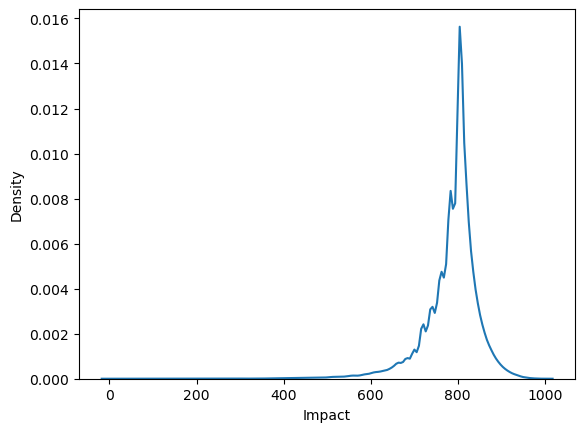

In [8]:
sns.kdeplot(df['Impact'])

## Show dimensions, columns, and datatypes

In [9]:
print("Dimensions: ", df.shape)
num_row = df.shape[0]
num_col = df.shape[1]
print(df.dtypes)

Dimensions:  (138724, 7)
Title             object
description       object
authors           object
publisher         object
publishedDate     object
categories        object
Impact           float64
dtype: object


In [10]:
#Number of NaN values
print(df.isna().sum())
print("Out of",num_row,"rows")

Title                0
description      12749
authors           2723
publisher            0
publishedDate      348
categories           0
Impact               0
dtype: int64
Out of 138724 rows


## Fill some NaNs

In [11]:
df['description'] = df['description'].fillna('')
df['authors'] = df['authors'].fillna('')

In [12]:
#Number of NaN values
print(df.isna().sum())
print("Out of",num_row,"rows")

Title              0
description        0
authors            0
publisher          0
publishedDate    348
categories         0
Impact             0
dtype: int64
Out of 138724 rows


## making all the date column which is in the format of y|

In [13]:
import pandas as pd

# Assuming df is your DataFrame with column 'publishedDate'

# Convert 'publishedDate' to datetime format, explicitly specifying UTC timezone
df['publishedDate'] = pd.to_datetime(df['publishedDate'], errors='coerce', utc=True)

# Check for rows with year only format and convert them to datetime
year_only_mask = df['publishedDate'].dt.year.notnull() & df['publishedDate'].dt.month.isna() & df['publishedDate'].dt.day.isna()
df.loc[year_only_mask, 'publishedDate'] = df.loc[year_only_mask, 'publishedDate'].astype(str) + '-01-01'

print(df)


                                                    Title  \
0                          Its Only Art If Its Well Hung!   
1                                Dr. Seuss: American Icon   
2                   Wonderful Worship in Smaller Churches   
3                           Whispers of the Wicked Saints   
4       The Church of Christ: A Biblical Ecclesiology ...   
...                                                   ...   
138719  The Magic of the Soul: Applying Spiritual Powe...   
138720               Autodesk Inventor 10 Essentials Plus   
138721  The Orphan Of Ellis Island (Time Travel Advent...   
138722                            Red Boots for Christmas   
138723                                  The Autograph Man   

                                              description  \
0                                                           
1       Philip Nel takes a fascinating look into the k...   
2       This resource includes twelve principles in un...   
3       Julia Thomas fi

In [14]:
df.isnull().sum(axis =0)

Title              0
description        0
authors            0
publisher          0
publishedDate    394
categories         0
Impact             0
dtype: int64

In [15]:
auxiliary_columns = ['publishedDate']
text_feature = ['Title','description','authors','publisher','categories']

In [16]:
def preprocess_data_part(data_part):
    data_part = data_part.drop(auxiliary_columns, axis=1)

    X = data_part.drop(['Impact'], axis=1)
    y = data_part['Impact']
    X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.25,  
                                   shuffle=True) 
  
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = preprocess_data_part(df)

In [17]:
X_train.columns.tolist()

['Title', 'description', 'authors', 'publisher', 'categories']

## Punctuation Removal

In [18]:
#library that contains punctuation


import string
string.punctuation


#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
for col in X_train.columns.tolist():
    X_train[col]= X_train[col].apply(lambda x:remove_punctuation(x))
X_train.head()


,Title,description,authors,publisher,categories
89012,Animal ghosts Or Animal hauntings and the here...,Animal Ghosts Or Animal Hauntings and the Here...,Elliott ODonnell,Good Press,Fiction
64111,Bush League Diplomacy How the Neoconservatives...,Fifty years ago the United States founded the ...,Craig R Eisendrath Melvin Allan Goodman,Prometheus Books,Political Science
57849,The Witchery Harper Fiction,New York Times bestselling author James Reese ...,James Reese,Harper,Fiction
109222,From Yalta to Berlin The Cold War Struggle Ove...,A history of Germany from the end of World War...,W R Smyser,Palgrave Macmillan,History
93660,So You Want To Be An Inventor,Presents some of the characteristics of invent...,Judith St George,Dorling Kindersley Ltd,Juvenile Nonfiction


## lowering all the string in all the txt columns

In [19]:
#lowering all the string
for col in X_train.columns.tolist():
    X_train[col]= X_train[col].apply(lambda x: x.lower())
X_train.head()

,Title,description,authors,publisher,categories
89012,animal ghosts or animal hauntings and the here...,animal ghosts or animal hauntings and the here...,elliott odonnell,good press,fiction
64111,bush league diplomacy how the neoconservatives...,fifty years ago the united states founded the ...,craig r eisendrath melvin allan goodman,prometheus books,political science
57849,the witchery harper fiction,new york times bestselling author james reese ...,james reese,harper,fiction
109222,from yalta to berlin the cold war struggle ove...,a history of germany from the end of world war...,w r smyser,palgrave macmillan,history
93660,so you want to be an inventor,presents some of the characteristics of invent...,judith st george,dorling kindersley ltd,juvenile nonfiction


## Stop Word Removal

In [20]:
#importing nlp library
import nltk
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')


#defining the function to remove stopwords from tokenized text
import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#applying the function
for col in X_train.columns.tolist():
    X_train[col]= X_train[col].apply(lambda x: tokenization(x)).apply(lambda x:remove_stopwords(x)).apply(lambda x: ' '.join(x))

X_train.head()

,Title,description,authors,publisher,categories
89012,animal ghosts or animal hauntings and the here...,animal ghosts or animal hauntings and the here...,elliott odonnell,good press,fiction
64111,bush league diplomacy how the neoconservatives...,fifty years ago the united states founded the ...,craig r eisendrath melvin allan goodman,prometheus books,political science
57849,the witchery harper fiction,new york times bestselling author james reese ...,james reese,harper,fiction
109222,from yalta to berlin the cold war struggle ove...,a history of germany from the end of world war...,w r smyser,palgrave macmillan,history
93660,so you want to be an inventor,presents some of the characteristics of invent...,judith st george,dorling kindersley ltd,juvenile nonfiction


## lemmetization

In [21]:
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
for col in X_train.columns.tolist():
    X_train[col]=X_train[col].apply(lambda x: tokenization(x)).apply(lambda x:lemmatizer(x)).apply(lambda x: ' '.join(x))
    
X_train.head()

,Title,description,authors,publisher,categories
89012,animal ghosts or animal hauntings and the here...,animal ghosts or animal hauntings and the here...,elliott odonnell,good press,fiction
64111,bush league diplomacy how the neoconservatives...,fifty years ago the united states founded the ...,craig r eisendrath melvin allan goodman,prometheus books,political science
57849,the witchery harper fiction,new york times bestselling author james reese ...,james reese,harper,fiction
109222,from yalta to berlin the cold war struggle ove...,a history of germany from the end of world war...,w r smyser,palgrave macmillan,history
93660,so you want to be an inventor,presents some of the characteristics of invent...,judith st george,dorling kindersley ltd,juvenile nonfiction


## Building tfidf vector

In [22]:
import pandas as pd
import numpy as np  # Import numpy for array manipulation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

# Assuming X is defined somewhere in your code

transformer = FeatureUnion([
                ('Title_tf_idf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['Title'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(max_features=9000))])),
                ('description_tf_idf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['description'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(max_features=9000))])),
                 ('authors_tf_idf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['authors'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(max_features=9000))])),
                 ('publisher_tf_idf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['publisher'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(max_features=9000))])),
                 ('categories_tf_idf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['categories'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(max_features=9000))]))]) 

result = transformer.fit_transform(X_train)



In [23]:
from sklearn.ensemble import RandomForestRegressor

# Create Random Forest Regressor object
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42,max_depth= 5,min_samples_leaf = 5,
                                     min_samples_split = 10)

# Train the Random Forest Regressor on the TF-IDF transformed data
rf_regressor.fit(result, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
predictions = rf_regressor.predict(result)

In [39]:
# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_train, predictions)


print("Mean Absolute percentage error:", mape)

Mean Absolute percentage error: 0.08801104886788219


## Processing the test data for prediction phase

In [27]:
#library that contains punctuation


import string
string.punctuation


#defining the function to remove punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
for col in X_test.columns.tolist():
    X_test[col]= X_test[col].apply(lambda x:remove_punctuation(x))
X_test.head()

,Title,description,authors,publisher,categories
65033,60 Planning ItLiving ItLoving It,Gives those approaching six decades advice on ...,Allan Fromme,New York Farrar Straus Giroux,Social Science
73319,Roots of Chicano Politics 16001940,This sweeping and original synthesis reinterpr...,Juan GómezQuiñones,Cumberland House Publishing,History
34744,Mystery of the Dark Tower a Bessie Mystery Ame...,A young girl’s life changes forever when she i...,Evelyn Coleman,Open Road Media,Juvenile Fiction
81746,Are You EVER Going to be Thin and other stories,Raymond Carver called Anton Chekhov the greate...,Anton Chekhov,Aeterna Classics,Fiction
102645,A woman rice planter,A collection of Pringles weekly columns in the...,Elizabeth Waties Allston Pringle,Tan Books Pub,African Americans


In [28]:
#lowering all the string
for col in X_test.columns.tolist():
    X_test[col]= X_test[col].apply(lambda x: x.lower())
X_test.head()

,Title,description,authors,publisher,categories
65033,60 planning itliving itloving it,gives those approaching six decades advice on ...,allan fromme,new york farrar straus giroux,social science
73319,roots of chicano politics 16001940,this sweeping and original synthesis reinterpr...,juan gómezquiñones,cumberland house publishing,history
34744,mystery of the dark tower a bessie mystery ame...,a young girl’s life changes forever when she i...,evelyn coleman,open road media,juvenile fiction
81746,are you ever going to be thin and other stories,raymond carver called anton chekhov the greate...,anton chekhov,aeterna classics,fiction
102645,a woman rice planter,a collection of pringles weekly columns in the...,elizabeth waties allston pringle,tan books pub,african americans


In [29]:
#importing nlp library
import nltk
#Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')


#defining the function to remove stopwords from tokenized text
import re
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens

def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

#applying the function
for col in X_test.columns.tolist():
    X_test[col]= X_test[col].apply(lambda x: tokenization(x)).apply(lambda x:remove_stopwords(x)).apply(lambda x: ' '.join(x))

X_test.head()

,Title,description,authors,publisher,categories
65033,60 planning itliving itloving it,gives those approaching six decades advice on ...,allan fromme,new york farrar straus giroux,social science
73319,roots of chicano politics 16001940,this sweeping and original synthesis reinterpr...,juan gómezquiñones,cumberland house publishing,history
34744,mystery of the dark tower a bessie mystery ame...,a young girl’s life changes forever when she i...,evelyn coleman,open road media,juvenile fiction
81746,are you ever going to be thin and other stories,raymond carver called anton chekhov the greate...,anton chekhov,aeterna classics,fiction
102645,a woman rice planter,a collection of pringles weekly columns in the...,elizabeth waties allston pringle,tan books pub,african americans


In [30]:
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
for col in X_test.columns.tolist():
    X_test[col]=X_test[col].apply(lambda x: tokenization(x)).apply(lambda x:lemmatizer(x)).apply(lambda x: ' '.join(x))
    
X_test.head()

,Title,description,authors,publisher,categories
65033,60 planning itliving itloving it,gives those approaching six decades advice on ...,allan fromme,new york farrar straus giroux,social science
73319,roots of chicano politics 16001940,this sweeping and original synthesis reinterpr...,juan gómezquiñones,cumberland house publishing,history
34744,mystery of the dark tower a bessie mystery ame...,a young girl’s life changes forever when she i...,evelyn coleman,open road media,juvenile fiction
81746,are you ever going to be thin and other stories,raymond carver called anton chekhov the greate...,anton chekhov,aeterna classics,fiction
102645,a woman rice planter,a collection of pringles weekly columns in the...,elizabeth waties allston pringle,tan books pub,african americans


In [31]:
test_result = transformer.transform(X_test)

In [33]:
test_predictions = rf_regressor.predict(test_result)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Absolute Error: 41.313199684405674
Mean Squared Error: 4024.9061351540595
R-squared: 0.024229187814350794


In [38]:
# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_test, test_predictions)


print("Mean Absolute percentage error:", mape)

Mean Absolute percentage error: 0.05801104886788219
